In [0]:
!mkdir Texts

In [0]:
cd Texts

In [0]:
!unzip /content/Flickr8k_text.zip

In [0]:
cd /content

In [0]:
pwd

In [0]:
!mkdir Images

In [0]:
cd Images

In [0]:
!unzip /content/Flickr8k_Dataset.zip

In [0]:
cd /content

In [0]:
import os
import pickle 
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [0]:
mod = VGG16()
mod.summary()

W0623 06:03:13.450803 139863730014080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 06:03:13.497400 139863730014080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 06:03:13.506817 139863730014080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 06:03:13.543949 139863730014080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 13s 0us/step


W0623 06:03:27.782792 139863730014080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0623 06:03:27.784268 139863730014080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def gfeature(directory):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# extract features from each photo
	features = {}
	for name in os.listdir(directory):
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		
	return features
 


In [0]:
directory = '/content/Images/Flicker8k_Dataset'
features = gfeature(directory)
pickle.dump(features, open('features.pkl', 'wb'))

In [0]:
def read_file(file):
  with open(file, "r") as f:
    txt = f.read()
    return txt

In [0]:
doc = read_file("/content/Texts/Flickr8k.token.txt")

In [0]:
def descriptions(doc):
	Dict = {}
	# process lines
	for l in doc.split('\n'):
		# split line by white space
		t = l.split()
		if len(l) < 2:
			continue
		# take the first token as the image id, the rest as the description
		iid, desc = t[0], t[1:]
		iid = iid.split('.')[0]
		# convert description tokens back to string
		desc = ' '.join(desc)
		# create the list if needed
		if iid not in Dict:
			Dict[iid] = []
		# store description
		Dict[iid].append(desc)
	return Dict

In [0]:
Descdict = descriptions(doc)

In [0]:
import string

In [0]:
def clean(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [0]:
clean(Descdict)

In [0]:
def create_vocab(desc):
	# build a list of all description strings
	all_desc = set()
	for key in desc.keys():
		[all_desc.update(d.split()) for d in desc[key]]
	return all_desc

In [0]:
vocabulary = create_vocab(Descdict)

In [0]:
def save_file(desc, filename):
  lines = []
  for key, desc_list in desc.items():
    for descr in desc_list:
      lines.append(key + ' ' + descr)
  data = '\n'.join(lines)
  with open(filename, 'w') as file:
    file.write(data)
	

In [0]:
save_file(Descdict, "descriptions.txt")

In [0]:
def load_set(filename):
	doc = read_file(filename)
	dataset = []
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [0]:
def clean_descriptions(filename, dataset):
	# load document
	doc = read_file(filename)
	description = {}
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in description:
				description[image_id] = []
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			description[image_id].append(desc)
	return description

In [0]:
def load_photo_features(filename, dataset):
	# load all features
	all_features = pickle.load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [0]:
filename_train = "/content/Texts/Flickr_8k.trainImages.txt"
train_descriptions = clean_descriptions('descriptions.txt', load_set(filename_train))

In [0]:
train_features = load_photo_features('features.pkl', load_set(filename_train))

In [0]:
def to_lines(descr):
	all_desc = []
	for key in descr.keys():
		[all_desc.append(d) for d in descr[key]]
	return all_desc

In [0]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(description):
	lines = to_lines(description)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
tokenizer = create_tokenizer(train_descriptions)

In [0]:
vsize = len(tokenizer.word_index) +1

In [0]:
lines = to_lines(train_descriptions)
max(len(d.split()) for d in lines)

34

34 is the maximum length of the descriptions(captions) for the images

In [0]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
def make_seq(tokenizer,desc_list, pics):
	X1, X2, y = [], [], []
	
	for desc in desc_list:
    
		seq = tokenizer.texts_to_sequences([desc])[0]
		# splitting one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# splitting into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# padding input sequence
			in_seq = pad_sequences([in_seq], maxlen=34)[0]
			
			out_seq = to_categorical([out_seq], num_classes=vsize)[0]
			
			X1.append(pics)
			X2.append(in_seq)
			y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

In [0]:
def DataGenerator(description, photos, tokenizer):
	# loop for ever over images
	while True:
		for key, desc_list in description.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = make_seq(tokenizer, desc_list, photo)
			yield [[in_img, in_seq], out_word]

In [0]:
Traingen = DataGenerator(train_descriptions, train_features, tokenizer)

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add

In [0]:
class ICG:
  def build(vocab_size):
	  # branch for Image input
	  inp_img = Input(shape=(4096,))
	  img = Dropout(0.5)(inp_img)
	  img = Dense(256, activation='relu')(img)
	  # branch for Word sequence input
	  inp_seq = Input(shape=(34,))
	  seq = Embedding(vocab_size, 256, mask_zero=True)(inp_seq)
	  seq = Dropout(0.5)(seq)
	  seq = LSTM(256)(seq)
	  # Combining both branches
	  comb = add([img, seq])
	  comb = Dense(256, activation='relu')(comb)
	  output = Dense(vocab_size, activation='softmax')(comb)
	  # tie it together [image, seq] [word]
	  model = Model(inputs=[inp_img, inp_seq], outputs=output)
	  
	
	  return model

In [0]:
model = ICG.build(vsize)

W0623 06:43:00.478328 140292479227776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0623 06:43:00.872858 140292479227776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [0]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="Caption.png", show_shapes=True, show_layer_names=True)

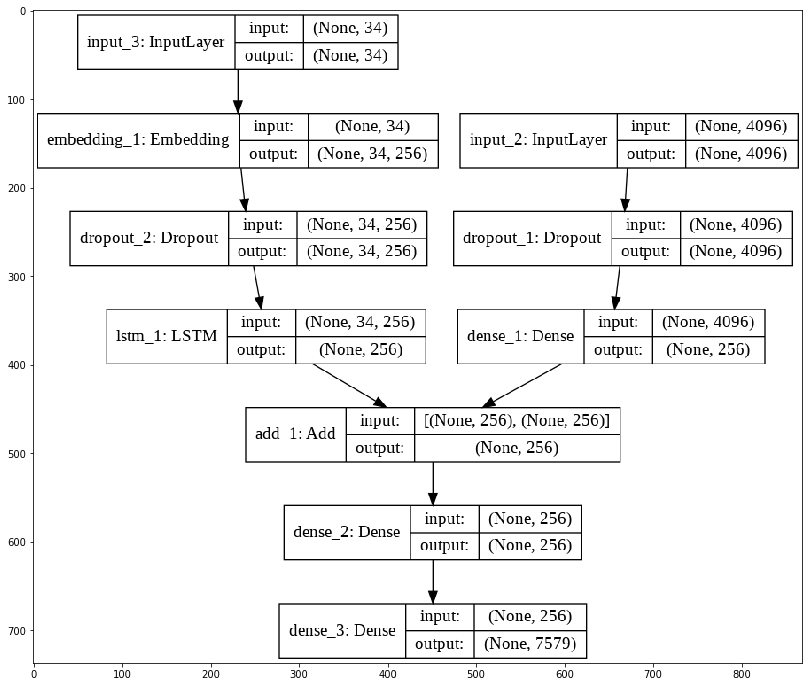

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
image = plt.imread("/content/Caption.png")
plt.imshow(image)
plt.show()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
filename_val = '/content/Texts/Flickr_8k.devImages.txt'
val_descriptions = clean_descriptions('descriptions.txt', load_set(filename_val))
val_features = load_photo_features('features.pkl', load_set(filename_val))


In [0]:
Valgen = DataGenerator(val_descriptions, val_features, tokenizer)

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [0]:
hist = model.fit_generator(Traingen, 
                           epochs=10, 
                           steps_per_epoch = len(train_descriptions), 
                           callbacks=[checkpoint],
                           validation_data = Valgen,
                           validation_steps = len(val_descriptions)
                            )

Epoch 1/10
6000/6000 [==============================] - 489s 81ms/step - loss: 4.6470 - val_loss: 4.2100

Epoch 00001: val_loss improved from inf to 4.21002, saving model to model-ep001-loss4.668-val_loss4.210.h5
Epoch 2/10
6000/6000 [==============================] - 486s 81ms/step - loss: 3.9212 - val_loss: 3.9628

Epoch 00002: val_loss improved from 4.21002 to 3.96280, saving model to model-ep002-loss3.940-val_loss3.963.h5
Epoch 3/10
6000/6000 [==============================] - 487s 81ms/step - loss: 3.6616 - val_loss: 3.9171

Epoch 00003: val_loss improved from 3.96280 to 3.91714, saving model to model-ep003-loss3.681-val_loss3.917.h5
Epoch 4/10
6000/6000 [==============================] - 490s 82ms/step - loss: 3.5111 - val_loss: 3.8992

Epoch 00004: val_loss improved from 3.91714 to 3.89922, saving model to model-ep004-loss3.532-val_loss3.899.h5
Epoch 5/10
6000/6000 [==============================] - 482s 80ms/step - loss: 3.4123 - val_loss: 3.8878

Epoch 00005: val_loss improved

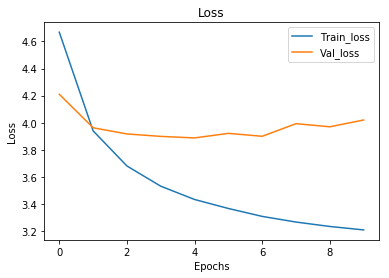

In [0]:
plt.plot(np.arange(0,10), hist.history["loss"], label="Train_loss")
plt.plot(np.arange(0,10), hist.history["val_loss"], label="Val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [0]:
def int_to_word(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [0]:
def generate_caption(model, tokenizer, image, beam_index=3):
	
	in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
	while len(in_text[0][0]) < 34:
		tempList = []
		for seq in in_text:
			padded_seq = pad_sequences([seq[0]], maxlen= 34)
			preds = model.predict([image,padded_seq], verbose=0)
			# Taking top  `beam_index` predictions
			top_preds = np.argsort(preds[0])[-beam_index:]
			 
			for word in top_preds:
				next_seq, prob = seq[0][:], seq[1]
				next_seq.append(word)
				
				prob += preds[0][word]
				# Appending as input for generating the next word
				tempList.append([next_seq, prob])
		in_text = tempList
		# Sorting according to the probabilities
		in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
		in_text = in_text[-beam_index:]
	in_text = in_text[-1][0]
	final_caption_raw = [int_to_word(i,tokenizer) for i in in_text]
	final_caption = []
	for word in final_caption_raw:
		if word=='endseq':
			break
		else:
			final_caption.append(word)
	final_caption.append('endseq')
	return ' '.join(final_caption)

In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [0]:
def evaluate_model(model, images, captions, tokenizer, beam_index=3):
	actual, predicted = [], []
	for image_id, caption_list in captions.items():
		yhat = generate_caption(model, tokenizer, images[image_id], beam_index=beam_index)
		ground_truth = [caption.split() for caption in caption_list]
		actual.append(ground_truth)
		predicted.append(yhat.split())
	print('BLEU Scores :')
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
from keras.models import load_model
model = load_model("/content/model-ep005-loss3.433-val_loss3.888.h5")

In [0]:
evaluate_model(model, val_features, val_descriptions, tokenizer)

BLEU Scores :
BLEU-1: 0.539268
BLEU-2: 0.296868
BLEU-3: 0.212282
BLEU-4: 0.108103


The model is not very good but not very bad either.

In [0]:
def extract_features(filename):
	
	model = VGG16()
	
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	
	image = load_img(filename, target_size=(224, 224))
	
	image = img_to_array(image)
	
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	
	image = preprocess_input(image)
	
	feature = model.predict(image, verbose=0)
	return feature



In [0]:
randomfiles = ["3457784061_8f77f43a9c.jpg",
"3364715316_df8c20bac1.jpg",
"233361142_d9d5f0cae9.jpg",
"634891010_9fa189effb.jpg",
"2977379863_2e8d7a104e.jpg",
"3663951804_868982f3f9.jpg"]

In [0]:
!pip install gtts

  Stored in directory: /root/.cache/pip/wheels/ac/d3/52/db6c154b20dfaab7e0b514eb5eef92cecd057e40e16fdda58b
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts gtts-token


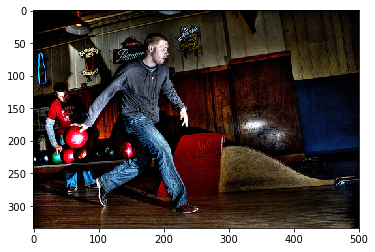

 man in blue shirt is sitting on the street 




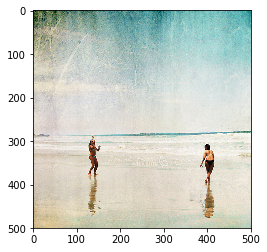

 two people are sitting on the beach in front of lake 




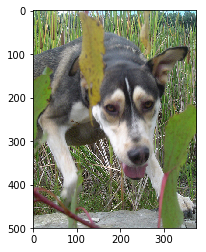

 black and white dog is running through the snow 




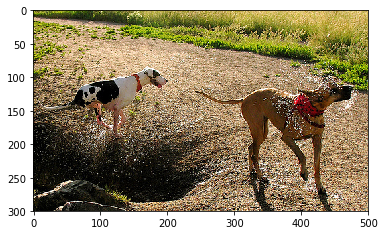

 black and white dog is running through the snow 




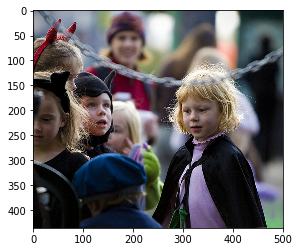

 man in blue shirt is sitting on the street 




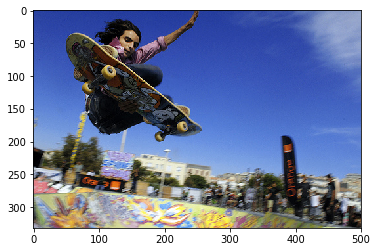

 young boy in blue shirt is riding bike in the air 




In [0]:
descr = []
for name in randomfiles:
  file = "/content/Images/Flicker8k_Dataset/" + name
  plt.imshow(plt.imread(file))
  plt.show()
  pic = extract_features(file)
  desc = generate_caption(model, tokenizer, pic, 3)
  descr.append(desc)
  print(desc[8:-6]) # Here, startseq and endseq words are omitted
  print("\n")

So, this model is good but not very excellent. It can be improved by tweaking the  Neural Network Model.

The texts generated can be converted into audio using the gtts (Google Text To Speech) API. 

In [0]:
from gtts import gTTS


In [0]:
for i in len(descr):
  tts = gTTS(text= descr[i][8:-6], lang='en')
  fn = "Caption" + str(i+1) +".mp3"
  tts.save(fn)


In [0]:
import IPython.display as ipd
ipd.Audio("Caption6.mp3")

So, finally  complete model converting an image into voice caption is ready. The model is not at its optimum and needs some improvement.